# 1. Setup

## 1.1 Install/Import Dependencies

In [1]:
!pip list -v

Package                      Version     Location                                                                   Installer
---------------------------- ----------- -------------------------------------------------------------------------- ---------
absl-py                      2.3.1       /home/nasir/FacialRecognitionSiameseModel/env/lib/python3.13/site-packages pip
anyio                        4.11.0      /home/nasir/FacialRecognitionSiameseModel/env/lib/python3.13/site-packages pip
apt-listchanges              4.8         /usr/lib/python3/dist-packages                                             debian
argon2-cffi                  25.1.0      /home/nasir/FacialRecognitionSiameseModel/env/lib/python3.13/site-packages pip
argon2-cffi-bindings         25.1.0      /home/nasir/FacialRecognitionSiameseModel/env/lib/python3.13/site-packages pip
arrow                        1.4.0       /home/nasir/FacialRecognitionSiameseModel/env/lib/python3.13/site-packages pip
asgiref                  

In [2]:
#Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from picamera2 import Picamera2

In [3]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.2 Create Folder Structure

In [4]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)



## 2. Collect Positives and Anchors

In [ ]:
#!unzip '/home/nasir/FacialRecognitionSiameseModel/lfw.zip' -d '/home/nasir/FacialRecognitionSiameseModel/lfw'

In [ ]:
#Move LFW Images to the following Repository data/negative
'''for directory in os.listdir('/home/nasir/FacialRecognitionSiameseModel/lfw/lfw-deepfunneled/lfw-deepfunneled'):
    for file in os.listdir(os.path.join('/home/nasir/FacialRecognitionSiameseModel/lfw/lfw-deepfunneled/lfw-deepfunneled',directory)):
        EX_PATH = os.path.join('/home/nasir/FacialRecognitionSiameseModel/lfw/lfw-deepfunneled/lfw-deepfunneled',directory,file)
        NEW_PATH = os.path.join(NEG_PATH,file)
        os.replace(EX_PATH, NEW_PATH)'''

In [ ]:
# Import uuid library to generate unique image names
import uuid

In [ ]:
uuid.uuid1()

In [ ]:

# Initialize the camera
picam2 = Picamera2()
    
# Create a preview configuration (640x480 is good for testing)
config = picam2.create_preview_configuration(main={"format": "XRGB8888", "size": (250, 250)})
picam2.configure(config)
    
# Start the camera
picam2.start()
    
print("Press 'q' to quit the camera feed.")
    
# Continuously capture frames and display them
while True:
    frame = picam2.capture_array()
    #Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
        
    #collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    cv2.imshow("PiCamera2 Feed", frame)
    
    # Exit when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    
# Clean up
cv2.destroyAllWindows()
picam2.stop()





In [ ]:
frame.shape

## 3. Load and Preprocess Images

### 3.1 Get Image Directories

In [7]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [11]:
dir_test = anchor.as_numpy_iterator()

In [12]:
dir_test.next()

b'data/anchor/0860061a-b83b-11f0-a223-2ccf67db9bc7.jpg'

In [15]:
def preprocess(file_path):
    #reads in image from the file_path in byte like format
    #byte like format is any object that supports the buffer protocol
	byte_img = tf.io.read_file(file_path)
    #Load/decode the image 
	img = tf.io.decode_jpeg(byte_img)
    #resize the image to 100 by 100 by 3 array
	img = tf.image.resize(img,(100,100))
    #pixel value is between 0 and 255
    #Scaling down the pixel value down by 255 to be between 0 and 1
	img = img / 255.0
    #returns the image
	return img

In [22]:
img = preprocess('data/anchor/0860061a-b83b-11f0-a223-2ccf67db9bc7.jpg')

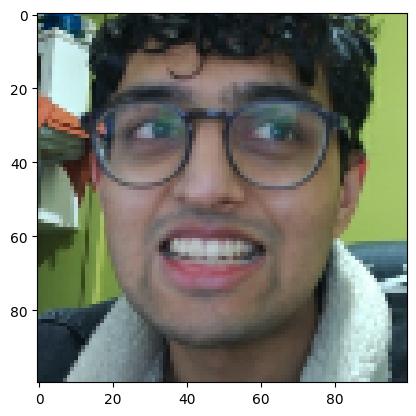

In [20]:
plt.imshow(img)

In [14]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

### 3.3 Create Labelled Dataset

In [34]:
#zips dataset and creates labelled dataset for positive images filled with 1 
#zipping allows us to iterate through all at same time
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
#zips dataset and creates labelled dataset for negative images filled with 0
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
#joining positives and negatives together to create one dataset
data = positives.concatenate(negatives)

In [35]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [38]:
samples = data.as_numpy_iterator()


In [65]:
example=samples.next()

### Build Train and Test Partition 

In [66]:
#passes the input and validation image through preprocessing 
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img),preprocess(validation_img),label)

In [67]:
res = preprocess_twin(*example)

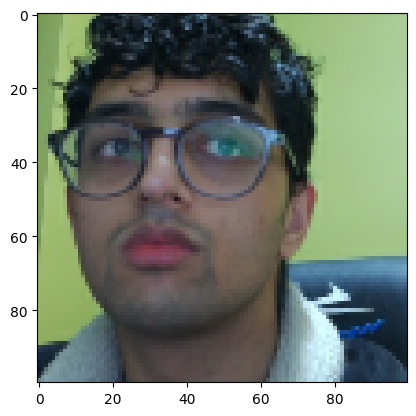

In [68]:
plt.imshow(res[1])